# Classification colors vs b&w drawing style using pre-trained resnet18
### https://www.kaggle.com/code/ggsri123/implementing-resnet18-for-image-classification

In [1]:
import matplotlib.pyplot as plt       # Plotting
import numpy as np                    # Tableau Multidimensionnel
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2, glob

from tqdm import tqdm
from datetime import datetime
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from glob import glob

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Preprocessing

In [3]:
train_data_dir = '../data/dessin/train_dessin'
test_data_dir = '../data/dessin/test_dessin'

In [4]:
from random import shuffle, seed

class Drawing(Dataset):
    def __init__(self, folder):
        bw = glob(folder+'/bw/*.jpeg')
        colors = glob(folder+'/colors/*.jpeg')
        
        self.fpaths = bw + colors
        #self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        seed(10)
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-2].startswith('bw') for fpath in self.fpaths] #--- class 0 : colors ------ class 1 : bw
        
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix] #prints path like ../data/dessin/train_dessin/bw/003_dessin.jpeg
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        #im = self.normalize(im) 
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [5]:
data = Drawing(train_data_dir)

# Plot data

tensor([1.])
bw


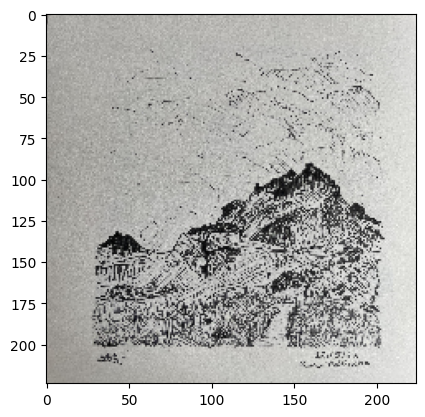

In [6]:
im, label = data[42]
# permute is to just keep it in the matplotlib way to display it
plt.imshow(im.permute(1,2,0).cpu())
print(label)
if label:
    print("bw")
else:
    print("colors")

# Recuperation of pretrained ResNet18
##### Adding some layers
- Linear
- ReLu
- Dropout
- Linear
- Sigmoid => between [0,1]

##### Loss Function is  BCE (Binary Cross Entropy for 2-class classification)
##### Adam optimizer with lr 1e-3

In [7]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [8]:
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

/mnt/c/users/magal/dev/magacrea-app/magacrea/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/c/users/magal/dev/magacrea-app/magacrea/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

# Function to train and eval model

In [9]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [10]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [11]:
def get_data():
    train_dataset = Drawing(train_data_dir)
    trn_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last = True)
    val_dataset = Drawing(test_data_dir)
    val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, drop_last = True)
    return trn_dataloader, val_dataloader

# Loading of data and model

In [12]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [13]:
train_losses, train_accuracies = [], []
val_accuracies = []
EPOCH=10

print("All losses and accuracies are for each epoch")
for epoch in tqdm(range(EPOCH)):
    
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print(f" epoch {epoch + 1}/5, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Validation Accuracy: {val_epoch_accuracy}")
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

All losses and accuracies are for each epoch


 10%|████████▌                                                                             | 1/10 [00:58<08:50, 58.96s/it]

 epoch 1/5, Training Loss: 0.7160976608594258, Training Accuracy: 0.5166666666666667, Validation Accuracy: 0.8333333333333334


 20%|█████████████████▏                                                                    | 2/10 [01:58<07:55, 59.42s/it]

 epoch 2/5, Training Loss: 0.49130011995633444, Training Accuracy: 0.8666666666666667, Validation Accuracy: 0.9444444444444444


 30%|█████████████████████████▊                                                            | 3/10 [02:59<07:01, 60.25s/it]

 epoch 3/5, Training Loss: 0.4091274549563726, Training Accuracy: 0.9166666666666666, Validation Accuracy: 0.9722222222222222


 40%|██████████████████████████████████▍                                                   | 4/10 [04:00<06:02, 60.42s/it]

 epoch 4/5, Training Loss: 0.47693206667900084, Training Accuracy: 0.95, Validation Accuracy: 0.9722222222222222


 50%|███████████████████████████████████████████                                           | 5/10 [04:59<04:59, 59.99s/it]

 epoch 5/5, Training Loss: 0.3153727432092031, Training Accuracy: 0.9333333333333333, Validation Accuracy: 0.75


 60%|███████████████████████████████████████████████████▌                                  | 6/10 [05:58<03:57, 59.45s/it]

 epoch 6/5, Training Loss: 0.3457243283589681, Training Accuracy: 1.0, Validation Accuracy: 0.9722222222222222


 70%|████████████████████████████████████████████████████████████▏                         | 7/10 [06:58<02:58, 59.63s/it]

 epoch 7/5, Training Loss: 0.25363973701993625, Training Accuracy: 1.0, Validation Accuracy: 0.9722222222222222


 80%|████████████████████████████████████████████████████████████████████▊                 | 8/10 [07:57<01:59, 59.51s/it]

 epoch 8/5, Training Loss: 0.3875224396586418, Training Accuracy: 1.0, Validation Accuracy: 0.9722222222222222


 90%|█████████████████████████████████████████████████████████████████████████████▍        | 9/10 [08:56<00:59, 59.25s/it]

 epoch 9/5, Training Loss: 0.18811513421436152, Training Accuracy: 1.0, Validation Accuracy: 0.9444444444444444


100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:55<00:00, 59.56s/it]

 epoch 10/5, Training Loss: 0.2563857731719812, Training Accuracy: 0.9833333333333333, Validation Accuracy: 1.0


/tmp/ipykernel_13348/765620694.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


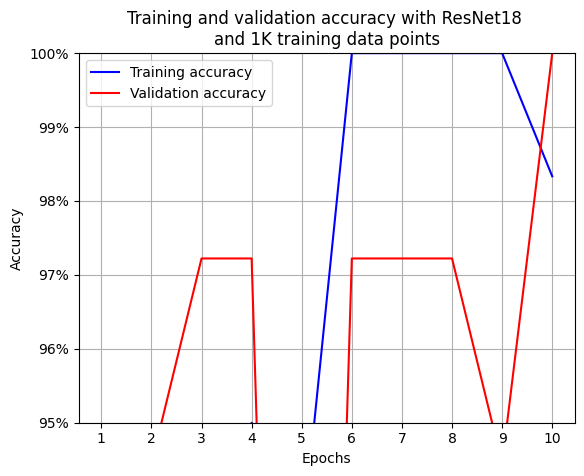

In [14]:
epochs = np.arange(EPOCH)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [15]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(timestamp)

20231117_005438


In [16]:
model_path = 'saved_models/model_{}'.format(timestamp)
torch.save(model.state_dict(), model_path)

# Inference

In [17]:
model_name = 'model_' + str(timestamp)
model_path = 'saved_models/' + model_name
saved_model, _, _ = get_model()

/mnt/c/users/magal/dev/magacrea-app/magacrea/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/c/users/magal/dev/magacrea-app/magacrea/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [19]:
train_bw_folder = glob('../data/dessin/train_dessin/bw/*.jpeg')
train_colors_folder = glob('../data/dessin/train_dessin/colors/*.jpeg')
test_bw_folder = glob('../data/dessin/test_dessin/bw/*.jpeg')
test_colors_folder = glob('../data/dessin/test_dessin/colors/*.jpeg')

In [20]:
paths = train_bw_folder + test_bw_folder + train_colors_folder + test_colors_folder

In [21]:
def transform_image(image_path):
    im = (cv2.imread(image_path)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    #im = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(im)
    return im.float().to(device)

In [22]:
def batch_sizing(x):
    return x[None,:]

In [23]:
class_predictions = []
saved_model.eval()
for im_path in paths : 
    x = batch_sizing(transform_image(im_path))  
    pred = saved_model(x)
    prediction = 'colors' if pred < 0.5 else 'bw'
    print(pred.item(), im_path.split('/')[-1], im_path.split('/')[-2], prediction)
    class_predictions.append(prediction)

0.9921635389328003 001_dessin.jpeg bw bw
0.9763997793197632 002_dessin.jpeg bw bw
0.9668046236038208 003_dessin.jpeg bw bw
0.9456607699394226 004_dessin.jpeg bw bw
0.9895886182785034 005_dessin.jpeg bw bw
0.9743417501449585 006_dessin.jpeg bw bw
0.9942307472229004 007_dessin.jpeg bw bw
0.9785230755805969 009_dessin.jpeg bw bw
0.9937026500701904 010_dessin.jpeg bw bw
0.9908071160316467 011_dessin.jpeg bw bw
0.9860023260116577 012_dessin.jpeg bw bw
0.9847742915153503 013_dessin.jpeg bw bw
0.9274295568466187 015_dessin.jpeg bw bw
0.9655113816261292 016_dessin.jpeg bw bw
0.9753284454345703 017_dessin.jpeg bw bw
0.9744341373443604 021_dessin.jpeg bw bw
0.9639805555343628 025_dessin.jpeg bw bw
0.9918181896209717 026_dessin.jpeg bw bw
0.9911378026008606 027_dessin.jpeg bw bw
0.9767286777496338 028_dessin.jpeg bw bw
0.9387959837913513 030_dessin.jpeg bw bw
0.9817967414855957 031_dessin.jpeg bw bw
0.975337564945221 033_dessin.jpeg bw bw
0.9468372464179993 034_dessin.jpeg bw bw
0.950388610363006

In [24]:
def plot_img(path):
    im = (cv2.imread(path)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(im)
    plt.imshow(im.permute(1,2,0))

In [25]:
#import time
#for path in paths[20:40] :
#    plot_img(path)
#    print(path)
#    plt.show()

In [27]:
x.shape

torch.Size([1, 3, 224, 224])